In [1]:
from src.tensor import Tensor
import src.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from mnist import MNIST
np.set_printoptions(suppress=True)

In [2]:
mndata = MNIST('./mnist_dataset/')
mndata.gz = True
training, test = mndata.load_training(), mndata.load_testing()

In [3]:
X = np.array(training[0] + test[0], dtype=float)
Y = np.array(list(training[1]) + list(test[1]), dtype=int)

# Scale down pixels from 0-255 to 0-1
X = X / 255.0

# OneHot label vectors
one_hot = np.zeros((Y.size, 10)) # (70000, 10)
one_hot[np.arange(Y.size), Y] = 1
Y = one_hot

In [4]:
# Split
n = len(X)
tr, d = int(n*0.8), int(n*0.9)
Xtr, Xdev, Xte = Tensor(X[:tr]), Tensor(X[tr:d]), Tensor(X[d:])
Ytr, Ydev, Yte = Tensor(Y[:tr]), Tensor(Y[tr:d]), Tensor(Y[d:])
print(f'Sizes: train={len(Xtr)}, val={len(Xdev)}, test={len(Xte)}')

Sizes: train=56000, val=7000, test=7000


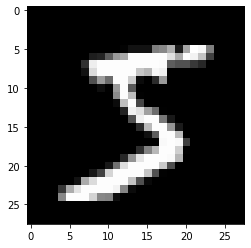

In [5]:
# Visualize X
img = np.array(Xtr[0].tolist())
plt.imshow(img.reshape(28, 28),cmap='gray')
plt.show()

In [33]:
# Multinomial sampling with replacement
rng = np.random.default_rng(seed=1)
def draw_batch(batch_size): 
    draw = lambda: int(rng.random() * len(Xtr))
    batch = [draw() for _ in range(batch_size)]
    return Xtr[batch], Ytr[batch]

def accuracy(split):
    x, y = {'train': (Xtr, Ytr), 'dev': (Xdev, Ydev), 'test': (Xte, Yte)}[split]
    global mlp
    x = mlp(x) # (7000, 10)
    correct = (x.data.argmax(1) == y.data.argmax(1)).sum()
    acc = (correct / len(x)) * 100
    print(f'{split}-accuracy: {acc:.2f}%')

In [50]:
mlp = nn.Sequential((
    nn.Linear(784, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10, bias=False),
    nn.Softmax()
))
mlp[0].W = mlp[0].W * 0.11
mlp[2].W = mlp[2].W * 0.07
mlp[4].W = mlp[4].W * 0.11
losses = []
dev_losses = []

std=1.0826534779105732
std=1.175290721185383
std=1.4574592790574887
std=7.007641837919825
Step 0: train=0.9041872087895253, val=0.6557148639896975
Step 1: train=1.1687462365208336, val=0.6487069997795024
Step 2: train=0.7247039538575144, val=0.640539663176291
Step 3: train=1.274714871880221, val=0.6408240646441518
Step 4: train=0.6351769112503995, val=0.6242820854495112
Step 5: train=0.6427449397930085, val=0.6189066072915241
Step 6: train=0.5983674272301106, val=0.6115514565024015
Step 7: train=0.8469782925008813, val=0.6116028331768237
Step 8: train=0.5126410911489718, val=0.6030561266874195
Step 9: train=1.2233033713674184, val=0.5979390903297197
Step 10: train=0.41215635041621596, val=0.5938542811545113
Step 11: train=0.9607924528028888, val=0.5905108231551521
Step 12: train=0.6762038489565636, val=0.5879904763450786
Step 13: train=0.3684757877233962, val=0.587109349890065
Step 14: train=0.803106404293695, val=0.5861191152412497
Step 15: train=0.7220330005798961, val=0.583108861412

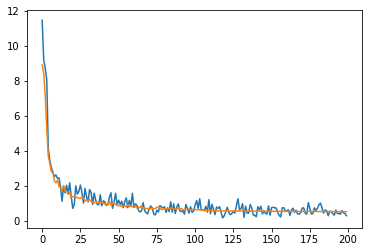

In [53]:
steps = 100
batch_size = 64
lr = 0.01
breakpoint = -1
for i in range(steps):
    x, y = draw_batch(batch_size)
    out = mlp(x, breakpoint=breakpoint, printstddev=(i==0))

    loss = nn.nlll(out, y, reduction='mean')
    loss.backward()

    mlp.optimize(lr=lr)
    mlp.zero_grad()

    loss = loss.data.item()
    losses.append(loss)
    dev_loss = nn.nlll(mlp(Xdev), Ydev, reduction='mean').data.item()
    dev_losses.append(dev_loss)
    print(f'Step {i}: train={loss}, val={dev_loss}')

plt.plot(losses, label='train')
plt.plot(dev_losses, label='dev')
plt.show()

In [52]:
accuracy('test')

test-accuracy: 85.27%
